In [1]:
import sys
from pathlib import Path

root_path = Path().cwd().parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from logic.regressor import predict

ONNX model loaded from /home/alumno/Desktop/datos/MLOPS/FINAL_PROJECT/MLOps_Final_Project/production/model/best_rf.onnx
Model expects input: float_input, shape: [None, 4]


2026-01-02 20:44:33.773989181 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 790444, index: 2, mask: {3, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.


In [2]:
dfp_test = pd.read_parquet("../data/processed/iter1/test/dfp_2024-10-01_2024-12-01_V.1.0.parquet")
dfp_drift = pd.read_parquet("../data/processed/iter1/drift/dfp_2023-10-01_2025-10-01_V.1.0.parquet")

In [3]:
dfp_predict = dfp_drift[dfp_drift.reporting_month > dfp_test.reporting_month.max()]

In [4]:
dfp_predict

,reporting_month,ISRC,continent,zone,quantity,revenue
166513,2025/01/01,CA-5KR-21-08251,Europe,Serbia and montenegro,5,7.650000e-07
166514,2025/01/01,CA-5KR-21-80967,Europe,Serbia and montenegro,5,7.650000e-07
166515,2025/01/01,FR-X20-23-35037,Asia,Kazakhstan,1,1.530000e-06
166516,2025/01/01,UNKNOWN,Asia,Kazakhstan,1,1.530000e-06
166517,2025/01/01,CA-5KR-21-80967,Europe,Ukraine,1,2.295000e-06
...,...,...,...,...,...,...
304889,2025/10/01,UNKNOWN,Europe,Germany,85161,2.645303e+02
304890,2025/10/01,UNKNOWN,Europe,France,89091,2.724789e+02
304891,2025/10/01,DG-A0M-23-83965,Europe,Germany,98452,2.954371e+02
304892,2025/10/01,UNKNOWN,North America,United states,121051,3.488069e+02


In [5]:
with open("../data/processed/iter1/train/dfp_2023-10-01_2024-10-01_V.1.0.json", 'r') as f:
    json_train = json.load(f)
keys_list = list(json_train.keys())

In [6]:
for k in keys_list[1:]:
    aux_map = {value: idx + 1 for idx, value in enumerate(json_train[k])}
    dfp_predict.loc[:, k] = dfp_predict[k].map(aux_map)

dfp_predict = dfp_predict.infer_objects(copy=False).fillna(0.0)

In [7]:
dfp_predict

,reporting_month,ISRC,continent,zone,quantity,revenue
166513,2025/01/01,22.0,3,123.0,5,7.650000e-07
166514,2025/01/01,62.0,3,123.0,5,7.650000e-07
166515,2025/01/01,194.0,2,68.0,1,1.530000e-06
166516,2025/01/01,0.0,2,68.0,1,1.530000e-06
166517,2025/01/01,62.0,3,142.0,1,2.295000e-06
...,...,...,...,...,...,...
304889,2025/10/01,0.0,3,47.0,85161,2.645303e+02
304890,2025/10/01,0.0,3,44.0,89091,2.724789e+02
304891,2025/10/01,140.0,3,47.0,98452,2.954371e+02
304892,2025/10/01,0.0,5,145.0,121051,3.488069e+02


In [8]:
X_drift = dfp_predict.copy().drop(columns=["revenue"])
y_drift = dfp_predict["revenue"]

In [9]:
# (quantity, isrc=None, continent=None, zone=None)
preds = predict(
    quantity = X_drift.quantity,
    isrc = X_drift.ISRC,
    continent = X_drift.continent,
    zone = X_drift.zone
)

In [10]:
dfp_predict['preds'] = preds
dfp_predict['square_error'] = (dfp_predict['revenue'] - dfp_predict['preds'])**2

dfp_predict['dummy_preds'] = (dfp_predict['quantity'] * 2) / 1000
dfp_predict['dummy_square_error'] = (dfp_predict['revenue'] - dfp_predict['dummy_preds'])**2

In [11]:
dfp_predict

,reporting_month,ISRC,continent,zone,quantity,revenue,preds,square_error,dummy_preds,dummy_square_error
166513,2025/01/01,22.0,3,123.0,5,7.650000e-07,0.008387,0.000070,0.010,0.000100
166514,2025/01/01,62.0,3,123.0,5,7.650000e-07,0.008387,0.000070,0.010,0.000100
166515,2025/01/01,194.0,2,68.0,1,1.530000e-06,0.001511,0.000002,0.002,0.000004
166516,2025/01/01,0.0,2,68.0,1,1.530000e-06,0.001511,0.000002,0.002,0.000004
166517,2025/01/01,62.0,3,142.0,1,2.295000e-06,0.001511,0.000002,0.002,0.000004
...,...,...,...,...,...,...,...,...,...,...
304889,2025/10/01,0.0,3,47.0,85161,2.645303e+02,235.981003,815.060957,170.322,8875.199127
304890,2025/10/01,0.0,3,44.0,89091,2.724789e+02,248.255966,586.752902,178.182,8891.914614
304891,2025/10/01,140.0,3,47.0,98452,2.954371e+02,267.428589,784.478312,196.904,9708.777480
304892,2025/10/01,0.0,5,145.0,121051,3.488069e+02,334.630676,200.965967,242.102,11385.940556


In [12]:
dfp_results = (
    dfp_predict
    .groupby(['reporting_month'], as_index=False)
    .agg(
        mean_revenue=('revenue', 'mean'),
        mean_preds=('preds','mean'),
        mean_dummy_preds=('dummy_preds','mean'),
        mse=('square_error', 'mean'),
        mse_dummy=('dummy_square_error', 'mean')
    )
).sort_values(
    by=['reporting_month'],
    ascending=[True]
)

dfp_results['rmse'] = np.sqrt(dfp_results['mse'])
dfp_results['dummy_rmse'] = np.sqrt(dfp_results['mse_dummy'])

In [13]:
def generate_range_with_noise(A, B, C):
    """
    Generates a linear range of 28 points between A and B with Gaussian noise.
    All values are guaranteed to be positive.
    
    Parameters:
    -----------
    A : float
        Lower bound of the range (must be positive)
    B : float
        Upper bound of the range (must be positive)
    C : float
        Standard deviation of the Gaussian noise (not applied to the last point)
    
    Returns:
    --------
    numpy.array : Array of 28 positive values with Gaussian noise (except the last one)
    """
    # Create linear range of 28 points
    range_array = np.linspace(A, B, 28)
    
    # Generate Gaussian noise for the first 27 points
    noise = np.random.normal(0, C, 27)
    
    # Add noise to all points except the last one
    range_array[:-1] += noise
    
    # Ensure all values are positive (clip at a small positive value)
    range_array = np.maximum(range_array, 0.0001)
    
    return range_array

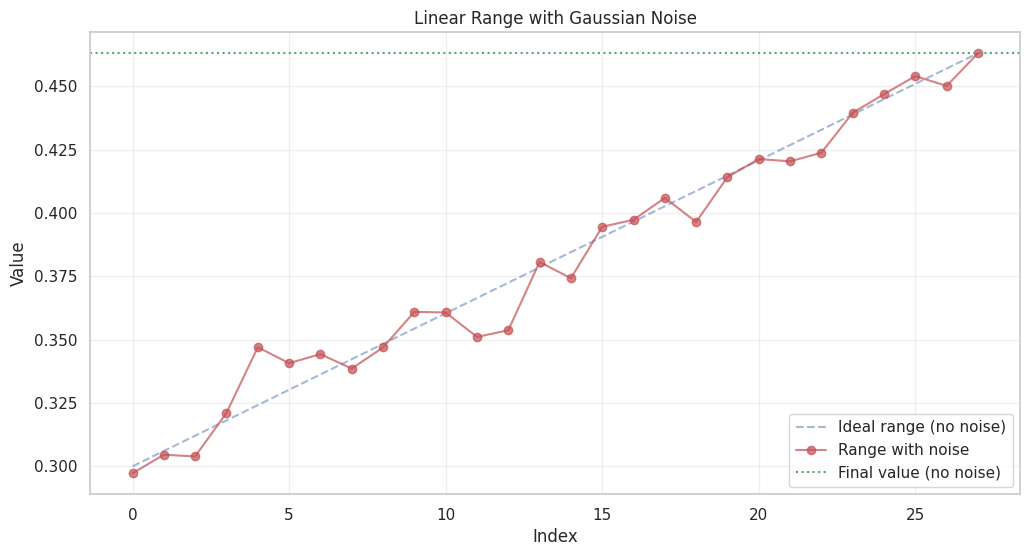

In [48]:
result = generate_range_with_noise(0.3, 0.463019, 0.01)

clean_range = np.linspace(0.3, 0.463019, 28)
plt.figure(figsize=(12, 6))
plt.plot(clean_range, 'b--', alpha=0.5, label='Ideal range (no noise)')
plt.plot(result, 'ro-', alpha=0.7, label='Range with noise')
plt.axhline(y=0.463019, color='g', linestyle=':', label='Final value (no noise)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Linear Range with Gaussian Noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
dfp_results.rmse.values

array([0.46301855, 1.20559233, 0.85118842, 0.83487927, 0.54649135,
       0.52210523, 1.33340921, 1.24418252, 1.75571656, 2.6214048 ])

In [15]:
noise = 0.04
results_list = []
dummy_results_list = []

for i in range(len(dfp_results)):
    if i == 0:
        result = generate_range_with_noise(
            dfp_results.iloc[i].rmse - 0.1, 
            dfp_results.iloc[i].rmse, 
            noise
        )
        dummy_result = generate_range_with_noise(
            dfp_results.iloc[i].dummy_rmse - 0.1, 
            dfp_results.iloc[i].dummy_rmse, 
            noise
        )
    else:
        result = generate_range_with_noise(
            dfp_results.iloc[i-1].rmse, 
            dfp_results.iloc[i].rmse, 
            noise
        )
        dummy_result = generate_range_with_noise(
            dfp_results.iloc[i-1].dummy_rmse, 
            dfp_results.iloc[i].dummy_rmse, 
            noise
        )
    results_list.append(result)
    dummy_results_list.append(dummy_result)

final_array = np.concatenate(results_list)
final_dummy_array = np.concatenate(dummy_results_list)

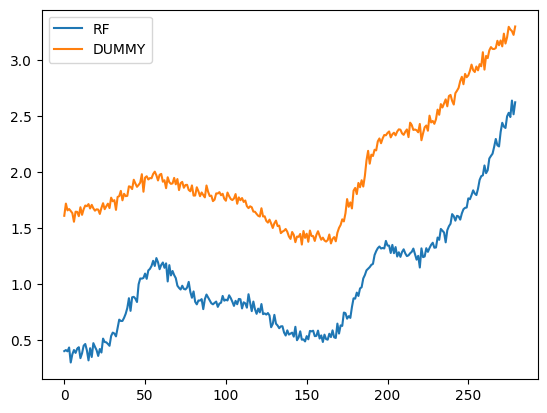

In [16]:
plt.plot(final_array, label = 'RF')
plt.plot(final_dummy_array, label = 'DUMMY')
plt.legend()
plt.show()

In [19]:
final_array

array([0.39894086, 0.40827991, 0.39676243, 0.43127043, 0.29739609,
       0.37079456, 0.40873781, 0.38287069, 0.4205725 , 0.43378144,
       0.33594387, 0.37961665, 0.44730072, 0.46240429, 0.40542806,
       0.31611789, 0.42467369, 0.34653954, 0.47008404, 0.43724792,
       0.40736947, 0.35565412, 0.41780174, 0.38613617, 0.51068959,
       0.48033659, 0.47730295, 0.46301855, 0.44632966, 0.53388957,
       0.56431248, 0.55601956, 0.53062225, 0.60583278, 0.6800099 ,
       0.66785073, 0.66858412, 0.69632606, 0.73229768, 0.78380827,
       0.87141802, 0.75854689, 0.87982722, 0.88363039, 0.86774781,
       0.83766023, 0.99558482, 1.04767834, 1.04646738, 1.05231941,
       1.09137511, 1.04456097, 1.11959227, 1.133361  , 1.15967884,
       1.20559233, 1.15950835, 1.2299809 , 1.19269435, 1.13063522,
       1.16920146, 1.19051032, 1.14330677, 1.18289112, 1.02123389,
       1.16676592, 1.07488671, 1.11460827, 1.07782022, 1.05093045,
       0.98344838, 0.9636334 , 0.94920331, 0.98291965, 0.95421

In [17]:
dfp_predict['absolut_error'] = abs(dfp_predict['revenue']-dfp_predict['preds'])

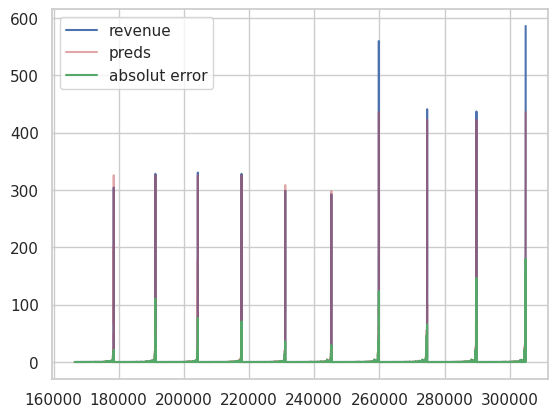

In [36]:
plt.plot(dfp_predict['revenue'], alpha = 1, label = 'revenue')
plt.plot(dfp_predict['preds'], color = 'r',alpha = 0.5, label = 'preds')
plt.plot(dfp_predict['absolut_error'], color = 'g', label = 'absolut error')
plt.legend()
plt.show()

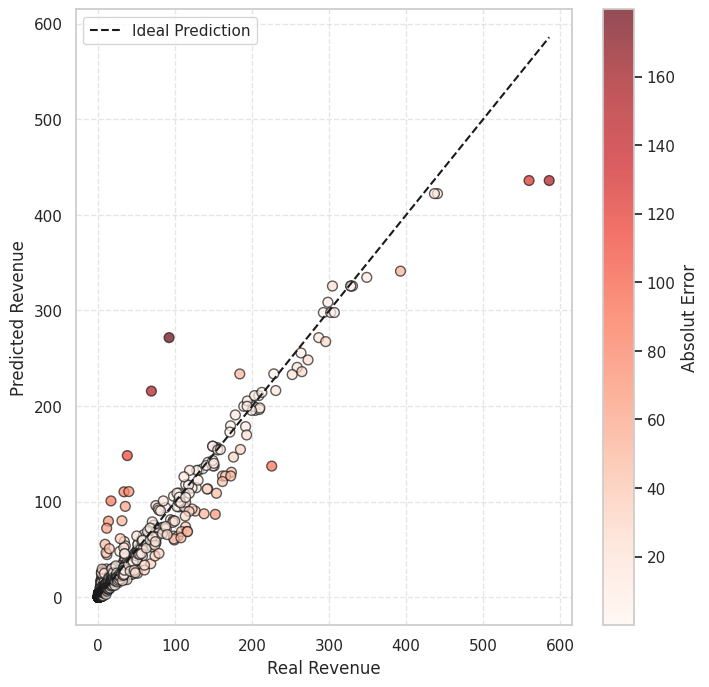

In [35]:
plt.figure(figsize=(8, 8))

scatter = plt.scatter(x=dfp_predict['revenue'], y=dfp_predict['preds'], 
                      c=dfp_predict['absolut_error'], cmap='Reds', 
                      edgecolor='k', alpha=0.7, s=50)

min_val = min(dfp_predict['revenue'].min(), dfp_predict['preds'].min())
max_val = max(dfp_predict['revenue'].max(), dfp_predict['preds'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Prediction')

plt.colorbar(scatter, label='Absolut Error')
# plt.title('', fontsize=14, fontweight='bold')
plt.xlabel('Real Revenue')
plt.ylabel('Predicted Revenue')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

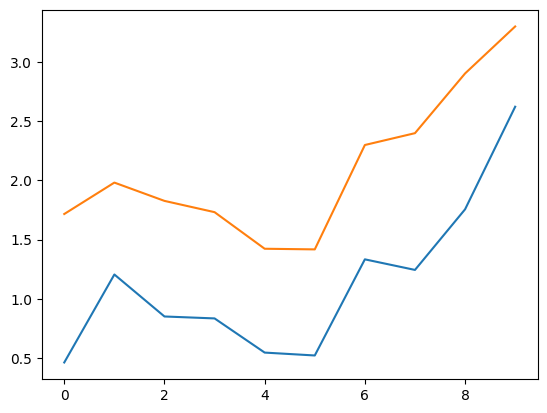

In [35]:
plt.plot(dfp_results['rmse'])
# plt.plot((dfp_results['rmse'] - dfp_results['dummy_rmse'])**2)
plt.plot(dfp_results['dummy_rmse'])
plt.show()